In [10]:
using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using HCubature

include("honeycomb.jl")
include("kanemele.jl")
include("latticeplot.jl")
include("berry.jl")
include("chern.jl")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
#rcParams["text.latex.preamble"] = [r"\usepackage{lmodern}", r"\usepackage{gensymb}", r"\usepackage{amsmath}"]

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

maxlinkdim (generic function with 2 methods)

# Haldane model

- [See Haldane PRL 1988]

The Bloch Hamiltonian is a 2x2 matrix
$$
H(\mathbf{k}) =
2t_2 \cos\phi \left[ \sum_i \cos(\mathbf{k}\cdot\mathbf{b}_i) \right] \sigma^0 +
t_1 \left[ \sum_i \cos(\mathbf{k} \cdot \mathbf{a_i}) \right] \sigma^1 +
t_1 \left[ \sum_i \sin(\mathbf{k} \cdot \mathbf{a_i}) \right] \sigma^2 +
$$
$$
+\left[m - 2t_2 \sin\phi \sum_i \sin(\mathbf{k}\cdot\mathbf{b_i}) \right] \sigma^3
$$
where $\sigma^\mu$ are Pauli matrices (with identity $\sigma^0$), $a_i$ are distance vectors between nearest neighbours and $b_i$ are between next-nearest neighbours. In the following, I set $t_1 = 1$ as unit of energy, and choose $t_2 = 0.1, \phi = \pi/2$. For this choice of parameters, the model is

 * topologically nontrivial for $|m| < 0.3\sqrt 3$ with Chern number $-1$,
 
 * trivial for $|m| > 0.3\sqrt 3$ (Chern number $0$)
 
 * and has a Dirac point for $|m| = 0.3\sqrt 3$ (Chern number $-1/2$).

Close to the transition, the gap at the dirac point is approximately $2\delta m$, where $\delta m = |m - 0.3\sqrt 3|$. Accordingly, we need a lattice with resolution $\sim \delta m$ to resolve the gap and get the correct Chern number.

In [11]:
pauli0 = [1. 0.; 0. 1.]
pauli = [
    [0. 1.; 1. 0.],
    [0. -1.0im; 1.0im 0.],
    [1. 0.; 0. -1.]
]

antisymmetricproduct(u, v) = u[1] * v[2] - u[2] * v[1]
    
function haldane(k, t2, ϕ, m)
    a::Vector{Vector{Float64}} =
    [
        [1, 0],
        [-0.5, 0.5sqrt(3)],
        [-0.5, -0.5sqrt(3)]
    ]
    b::Vector{Vector{Float64}} = [a[2] - a[3], a[3] - a[1], a[1] - a[2]]

    return 2 * t2 * cos(ϕ) * sum(cos(k' * bi) for bi in b) * pauli0 +    # NNN hopping
        sum(cos(k' * ai) * pauli[1] + sin(k' * ai) * pauli[2] for ai in a) + # NN hopping
        (m - 2 * t2 * sin(ϕ) * sum(sin(k' * bi) for bi in b)) * pauli[3]    # staggered offset
end

haldane (generic function with 1 method)

Gap ≈ 1.9999999999686935e-5


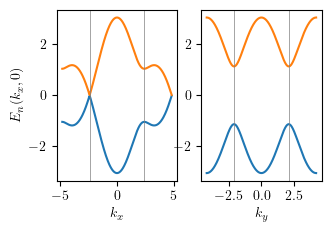

In [12]:
deltam = -1e-5

t2 = 0.1
phi = pi/2
m = 3sqrt(3) * t2 + deltam

nplot = 400

BZedgex = 4pi / 3
BZedgey = 8pi / (3sqrt(3))
kxplot = range(-BZedgex, BZedgex; length=nplot)
kyplot = range(-BZedgey, BZedgey; length=nplot)

bands = [eigvals(haldane([kx, ky], t2, phi, m)) for kx in kxplot, ky in kyplot]

fig, axs = subplots(ncols=2, figsize=(246/72, 160/72))
axs[1].plot(kyplot, bands[div(nplot, 2), :]);
axs[2].plot(kxplot, bands[:, div(nplot, 2)]);

axs[1].axvline(-4pi/(3sqrt(3)), color="gray", linewidth=0.5)
axs[1].axvline(4pi/(3sqrt(3)), color="gray", linewidth=0.5)

axs[2].axvline(-2pi / 3, color="gray", linewidth=0.5)
axs[2].axvline(2pi / 3, color="gray", linewidth=0.5)

axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_y$")
axs[1].set_ylabel(L"$E_n(k_x, 0)$")

gap = minimum(b[2] for b in bands) - maximum(b[1] for b in bands)
println("Gap ≈ $gap")

Cuts through the band structure. Gray lines are boundaries of the BZ. At one of the boundaries, we almost have a dirac point. This is where the Berry curvature will be strongly peaked.

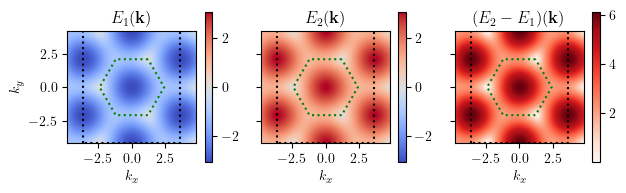

In [13]:
BZcontour = [
    [2pi / 3, 2pi/(3sqrt(3))],
    [2pi / 3, -2pi/(3sqrt(3))],
    [0, -4pi/(3sqrt(3))],
    [-2pi / 3, -2pi/(3sqrt(3))],
    [-2pi / 3, 2pi/(3sqrt(3))],
    [0, 4pi/(3sqrt(3))],
    [2pi / 3, 2pi/(3sqrt(3))],
]

intdomain = [
    [-4pi / 3, -6pi / (3sqrt(3))],
    [4pi / 3, -6pi / (3sqrt(3))],
    [4pi / 3, 6pi / (3sqrt(3))],
    [-4pi / 3, 6pi / (3sqrt(3))],
    [-4pi / 3, -6pi / (3sqrt(3))],
]

fig, axs = subplots(ncols=3, sharey=true, figsize=(510/72, 140/72))

vmax = maximum([maximum(abs.(b)) for b in bands])
extent = [-BZedgey, BZedgey, -BZedgex, BZedgex]
intextent = [-2pi/sqrt(3), 2pi/sqrt(3), -4pi/3, 4pi/3]

axs[1].imshow([b[1] for b in bands], cmap="coolwarm", vmin=-vmax, vmax=vmax, extent=extent) |> colorbar
axs[2].imshow([b[2] for b in bands], cmap="coolwarm", vmin=-vmax, vmax=vmax, extent=extent) |> colorbar
axs[3].imshow([b[2] - b[1] for b in bands], cmap="Reds", extent=extent) |> colorbar

for ax in axs
    ax.plot(
        [y for (x, y) in BZcontour],
        [x for (x, y) in BZcontour],
        "g:"
    )
    ax.plot(
        [y for (x, y) in intdomain],
        [x for (x, y) in intdomain],
        "k:"
    )
end

axs[1].set_title(L"$E_1(\mathbf{k})$")
axs[2].set_title(L"$E_2(\mathbf{k})$")
axs[3].set_title(L"$(E_2 - E_1)(\mathbf{k})$")

axs[1].set_ylabel(L"$k_y$")
axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_x$")
axs[3].set_xlabel(L"$k_x$");

Band structure and gap as a function of $\mathbf k$. The green hexagon is the first BZ. Since we integrate over a rectangle, I will assemble parts of multiple BZ to a rectangular integration domain (black) and then divide by 4 to account for the increased volume.

Chern number from direct sum: -0.4999999999999983
Time for eval: 1.030260416
Time for sum: 5.45e-5


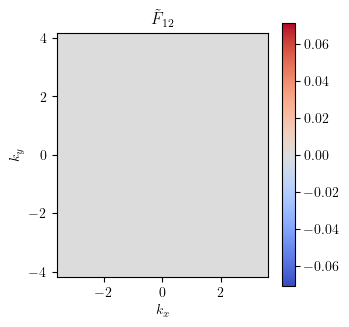

In [14]:
domainboundx = [-4pi/3, 4pi/3]
domainboundy = [-6pi/(3sqrt(3)), 6pi/(3sqrt(3))]

ndirect = 2^9
kxdirect = range(domainboundx...; length=ndirect+1)
kxdirect = (kxdirect[2:end] + kxdirect[1:ndirect]) / 2
kydirect = range(domainboundy...; length=ndirect+1)
kydirect = (kydirect[2:end] + kydirect[1:ndirect]) / 2

fig, axs = subplots(figsize=(246/72, 246/72))
timedirecteval = @elapsed A = chern.berrycurvature_dets([haldane([kx, ky], t2, phi, m) for kx in kxdirect, ky in kydirect], 1)
timedirectsum = @elapsed cdirect = sum(A) / 2pi / 4

vmax = maximum(abs.(A))
axs.imshow(A, cmap="coolwarm", vmin=-vmax, vmax=vmax, extent=intextent) |> colorbar

axs.set_title(L"$\tilde F_{12}$")
axs.set_xlabel(L"$k_x$")
axs.set_ylabel(L"$k_y$")

println("Chern number from direct sum: $cdirect")
println("Time for eval: $timedirecteval")
println("Time for sum: $timedirectsum")

This is the Berry curvature; unfortunately, it is so strongly peaked that a linear plot seems blank (log plot below). For direct evaluation, I cannot afford a very large lattice. As I'm summing over 4 copies of the BZ, there should be 4 peaks with a contribution of -1 each. Due to insufficient resolution, some of the peaks only contribute -0.5 to the sum, and after dividing by 4, the resulting Chern number is incorrect.

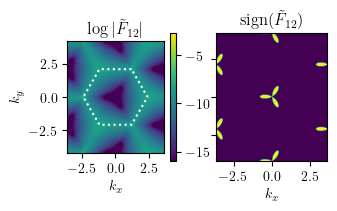

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x17d5475e0>

In [15]:
fig, axs = subplots(ncols=2, sharey=true, figsize=(246/72, 120/72))
axs[1].imshow(log.(abs.(A)), vmin=-16, extent=intextent) |> colorbar
axs[2].imshow(sign.(A), extent=intextent)

axs[1].set_title(L"$\log|\tilde{F}_{12}|$")
axs[2].set_title(L"$\mathrm{sign}(\tilde{F}_{12})$")
axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_x$")
axs[1].set_ylabel(L"$k_y$");

axs[1].plot(
    [y for (x, y) in BZcontour],
    [x for (x, y) in BZcontour],
    "w:"
)

In [16]:
fig, axs = subplots(figsize=(246/72, 150/72))

step = div(nplot, 32)
quarter = div(nplot, 4)
axs.semilogy(kyplot, abs.(A[2*quarter+1:step:3*quarter+1, :]'));

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/Ritter.Marc/.julia/packages/PyCall/ygXW2/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (400,) and (512, 9)')
  File "/Users/Ritter.Marc/.pyenv/versions/3.8.15/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1897, in semilogy
    return self.plot(
  File "/Users/Ritter.Marc/.pyenv/versions/3.8.15/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1662, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/Users/Ritter.Marc/.pyenv/versions/3.8.15/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/Users/Ritter.Marc/.pyenv/versions/3.8.15/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "


# QTCI rep

With QTCI, we can do better. As the gap has order $\delta m \approx 10^{-3}$, I need more than $10^3$ points; accordingly, I choose $N = 12$.

[1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], -3.8067276300068897e-6
walltime: 401.31105875


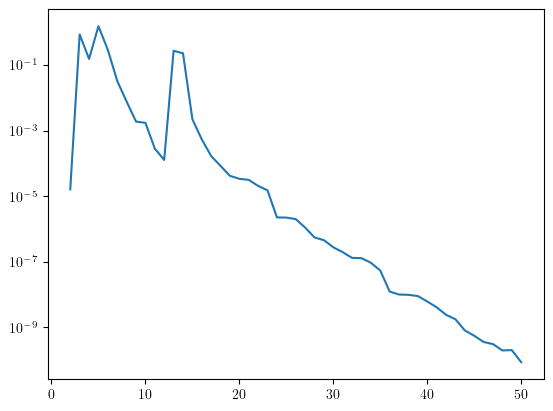

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x17f0459d0>

In [18]:
nquantics = 20
ndiscretization = 2^nquantics
kxvals = range(domainboundx..., length=ndiscretization+1)
kxvals = 0.5 .* (kxvals[1:ndiscretization] .+ kxvals[2:end])
kyvals = range(domainboundy..., length=ndiscretization+1)
kyvals = 0.5 .* (kyvals[1:ndiscretization] .+ kyvals[2:end])

oosindices = [rand([1, 2], nquantics) for _ in 1:2000]

function scalar(a::Matrix)
    if size(a) == (1, 1)
        return first(a)
    else
        throw(ArgumentError("$a is not a scalar."))
    end
end

function evaluate_qtt(qtt, q::Vector{<:Integer})
    return scalar(prod(T[:, i, :] for (T, i) in zip(qtt, q)))
end

struct cachedfunc{ValueType}
    f::Function
    d::Dict{Vector{Int}, ValueType}
    
    function cachedfunc(::Type{ValueType}, f::Function) where ValueType
        new{ValueType}(f, Dict())
    end
end
    
function (cf::cachedfunc{ValueType})(x::Vector{Int})::ValueType where {ValueType}
    if haskey(cf.d, x)
        return cf.d[x]
    else
        val = cf.f(x)
        cf.d[deepcopy(x)] = val
        return val
    end
end
    
Base.broadcastable(x::cachedfunc) = Ref(x)

function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

function maxrelerror(f, qtt::Vector{Array{Float64, 3}}, indices::Vector{Vector{Int}})
   return maximum(abs(f(i) - evaluate_qtt(qtt, i)) / abs(f(i)) for i in indices)
end
        
function maxabserror(f, qtt::Vector{Array{Float64, 3}}, indices::Vector{Vector{Int}})
    return maximum(abs(f(i) - evaluate_qtt(qtt, i)) for i in indices)
end

function crossinterpolate_chern(
    ::Type{ValueType},
    f,
    localdims::Vector{Int},
    firstpivot::TCI.MultiIndex=ones(Int, length(localdims));
    tolerance::Float64=1e-8,
    maxiter::Int=200,
    sweepstrategy::TCI.SweepStrategies.SweepStrategy=TCI.SweepStrategies.back_and_forth,
    pivottolerance::Float64=1e-12,
    verbosity::Int=0,
    normalizeerror=true
) where {ValueType}
    tci = TCI.TensorCI{ValueType}(f, localdims, firstpivot)
    n = length(tci)
    errors = Float64[]
#    relativeerrors = Float64[]
    ooserrors = Float64[]
    inserrors = Float64[]
    cherns = Float64[]
    ranks = Int[]

    # Start at two, because the constructor already added a pivot everywhere.
    for iter in 2:maxiter
        foward_sweep = (
            sweepstrategy == TCI.SweepStrategies.forward ||
            (sweepstrategy != TCI.SweepStrategies.backward && isodd(iter))
        )

        if foward_sweep
            TCI.addpivot!.(tci, 1:n-1, f, pivottolerance)
        else
            TCI.addpivot!.(tci, (n-1):-1:1, f, pivottolerance)
        end
        
        tt = TCI.tensortrain(tci)
        insindices = collect(setdiff(keys(f.d), oosindices))
#        push!(relativeerrors, maxrelerror(f, tt, insindices))
        push!(inserrors, maxabserror(f, tt, insindices))
        push!(ooserrors, maxabserror(f, tt, oosindices))

        push!(errors, TCI.lastsweeppivoterror(tci))
        push!(ranks, maximum(rank(tci)))
        push!(cherns, sumqtt(TCI.tensortrain(tci))  / 2pi)

        if verbosity > 0 && mod(iter, 10) == 0
            println("rank = $(last(ranks)), error = $(last(errors))")
        end
        
        errornormalization = normalizeerror ? tci.maxsamplevalue : 1.0
        if last(errors) < tolerance * errornormalization
            break
        end
    end

    errornormalization = normalizeerror ? tci.maxsamplevalue : 1.0    
    return tci, ranks, errors ./ errornormalization, inserrors, ooserrors, cherns
end

f(q) = chern.berrycurvature_quantics_dets(
    kindex -> haldane([kxvals[kindex[1]], kyvals[kindex[2]]], t2, phi, m),
    1, q, nquantics)
    
cf = cachedfunc(Float64, f)

dims = fill(4, nquantics)

#proposedpivots = [TCI.optfirstpivot(f, dims, rand([1, 2, 3, 4], nquantics)) for p in 1:1000]
#firstpivot = proposedpivots[argmax(cf.(proposedpivots))]
firstpivot = TCI.optfirstpivot(f, dims)
println("$firstpivot, $(cf(firstpivot))")

walltime = @elapsed tci, ranks, errors, inserrors, ooserrors, cherns = crossinterpolate_chern(
    Float64,
    cf,
    dims,
    firstpivot,
    tolerance=1e-10,
    pivottolerance=1e-16,
    maxiter=200,
);

println("walltime: $walltime")
semilogy(ranks, errors)

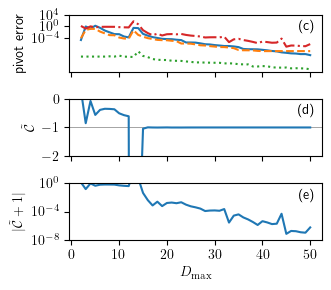

In [19]:
fig, axs = subplots(nrows=3, sharex=true, figsize=[246/72, 300/100])

axs[1].semilogy(ranks, errors)
#axs[1].semilogy(ranks, relativeerrors)
axs[1].semilogy(ranks, inserrors, "--")
axs[1].semilogy(ranks, ooserrors, ":")
axs[1].semilogy(ranks, abs.(cherns ./ 4 .+ 1), "-.")
axs[1].set_ylabel("pivot error")
axs[1].set_yticks(10. .^ [4, 0, -4])

for c in [-1, 0, 1]
    axs[2].axhline(c, color="gray", linewidth=0.5)
end
axs[2].plot(ranks, cherns ./ 4)
axs[2].set_ylabel(L"$\tilde{\mathcal{C}}$")
axs[2].set_ylim(-2, 0)

axs[3].semilogy(ranks, abs.(cherns ./ 4 .+ 1))
axs[3].set_ylabel(L"$|\tilde{\mathcal{C}}+1|$")
axs[3].set_ylim(10. .^ [-8, 0])
axs[3].set_yticks(10. .^ [0, -4, -8])

axs[3].set_xlabel(L"$D_{\max}$")

for (ax, label) in zip(axs, ["(c)", "(d)", "(e)"])
    ax.annotate(
        label,
        xy=(1, 1),
        xycoords="axes fraction",
        horizontalalignment="right",
        verticalalignment="top",
        xytext=(-4, -4),
        textcoords="offset points"
    );
end

tight_layout()

fig.savefig("haldane-convergence.pdf")

At bond dimension $\approx 40$, the result is converged very well. Note that this QTCI is nontrivial: We have multiple copies of the BZ, and we're asking TCI to find all of the peaks. And it does, because the peaks are not infinitely sharp.

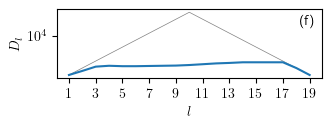

In [39]:
fig, axs = subplots(figsize=(246/72, 100/72))
axs.semilogy(1:nquantics-1, maxlinkdim(nquantics, 4)[2], color="gray", linewidth=0.5)
axs.semilogy(1:nquantics-1, TCI.linkdims(tci))
axs.set_ylabel(L"$D_l$")
axs.set_xlabel(L"$l$")
axs.set_xticks(1:2:nquantics-1);
axs.annotate(
    "(f)",
    xy=(1, 1),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="top",
    xytext=(-4, -4),
    textcoords="offset points"
);

tight_layout()

fig.savefig("haldane-Dl.pdf")

In [40]:
nplot = 1024
plotstep = div(ndiscretization, nplot)

tt = TCI.tensortrain(tci)
qttdata = [
    evaluate_qtt(tt, merge_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
    for kxi in 1:plotstep:length(kxvals), kyi in 1:plotstep:length(kyvals)
];

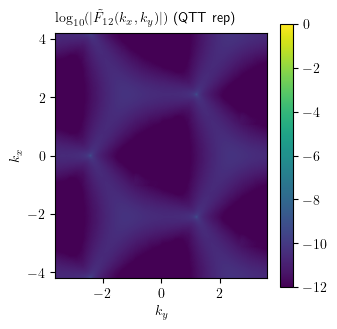

In [41]:
plottransform2(x) = log10(abs(x))
cmap = "viridis"

vmin = max(
    min(minimum(plottransform2.(qttdata))...),
    -12)
vmax = max(0, maximum.(plottransform2.(qttdata))...)


fig, axs = subplots(figsize=(246/72, 246/72))
axs.imshow(plottransform2.(qttdata), cmap=cmap, vmin=vmin, vmax=vmax, extent=intextent) |> colorbar

axs.annotate(
    L"$\log_{10}(|\tilde{F}_{12}(k_x, k_y)|)$ (QTT rep)",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(0, 8),
    textcoords="offset points"
)

axs.set_ylabel(L"$k_x$")
axs.set_xlabel(L"$k_y$");

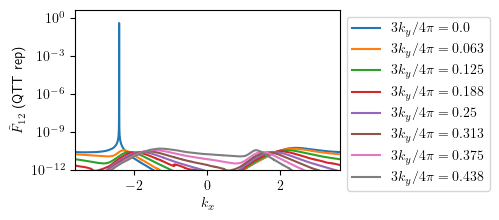

In [42]:
fig, axs = subplots(figsize=(246/72, 150/72))

step = div(ndiscretization, 32)
quarter = div(ndiscretization, 4)
for kxi in 2*quarter+1:step:3*quarter
    data = [
        evaluate_qtt(tt, merge_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
        for kyi in 1:ndiscretization
    ]
    axs.semilogy(kyvals, abs.(data), label="\$3k_y/4\\pi=$(round(kxvals[kxi] * 0.75 / pi; digits=3))\$")
end

axs.set_xlim(kyvals[1], kyvals[end])
axs.set_ylim(1e-12, axs.get_ylim()[2])
axs.set_xlabel(L"$k_x$")
axs.set_ylabel(L"$\tilde F_{12}$ (QTT rep)")
axs.legend(bbox_to_anchor=(1, 1), loc="upper left");

Cuts through the BZ. The peaks are 6 orders of magnitude larger than the background. (This plot is different than the first one due to different lattice size.)

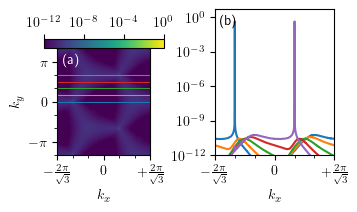

In [43]:
plottransform2(x) = log10(abs(x))
cmap = "viridis"

vmin = max(
    min(minimum(plottransform2.(qttdata))...),
    -12)
vmax = max(0, maximum.(plottransform2.(qttdata))...)

fig = figure(figsize=(246/72, 140/72))
ax_contourplot = fig.add_axes((0.1, 0.25, 0.35, 0.55))
ax_colorbar =    fig.add_axes((0.1, 0.8, 0.35, 0.05))
ax_lineplot =    fig.add_axes((0.6, 0.25, 0.35, 0.75))

contourplot = ax_contourplot.imshow(
    plottransform2.(qttdata),
    cmap=cmap, vmin=vmin, vmax=vmax, extent=intextent)
colorbar(contourplot, cax=ax_colorbar, orientation="horizontal")
ax_colorbar.tick_params(top=true, labeltop=true, bottom=false, labelbottom=false)
ax_colorbar.set_xticks([-12, -8, -4, 0], [L"$10^{-12}$", L"$10^{-8}$", L"$10^{-4}$", L"$10^0$"])

ax_contourplot.set_ylabel(L"$k_y$")
ax_contourplot.set_xlabel(L"$k_x$")

step = div(ndiscretization, 16)
quarter = div(ndiscretization, 4)
for kxi in 2*quarter+1:step:3*quarter+1
    data = [
        evaluate_qtt(tt, merge_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
        for kyi in 1:ndiscretization
    ]
    line = ax_lineplot.semilogy(kyvals, abs.(data))[1]
    ax_contourplot.axhline(kxvals[kxi], color=line.get_color(), linewidth=0.75)
end

ax_lineplot.set_xlim(kyvals[1], kyvals[end])
ax_lineplot.set_ylim(1e-12, axs.get_ylim()[2])
ax_lineplot.set_xlabel(L"$k_x$")
#ax_lineplot.set_ylabel(L"$\tilde F_{12}$ (QTT rep)")
#ax_lineplot.legend(bbox_to_anchor=(1, 1), loc="upper left");

ax_contourplot.set_yticks(
    minor=true,
    [-4pi/3, -2pi/3, -pi/3, 0, pi/3, 2pi/3, 4pi/3]
)
ax_contourplot.set_yticks(
    [-pi, 0, pi],
    [L"$-\pi$", L"$0$", L"$\pi$"]
)

for ax in [ax_contourplot, ax_lineplot]
    ax.set_xticks(
        minor=true,
        [-4pi/(3sqrt(3)), -2pi/(3sqrt(3)), 0, 4pi/(3sqrt(3)), 2pi/(3sqrt(3))]
    )
    ax.set_xticks(
        [-2pi/(sqrt(3)), 0, 2pi/(sqrt(3))],
        [L"$-\frac{2\pi}{\sqrt{3}}$", L"$0$", L"$+\frac{2\pi}{\sqrt{3}}$"]
    )
end

ax_contourplot.annotate(
    "(a)",
    xy=(0, 1),
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    xytext=(4, -4),
    textcoords="offset points",
    color="white"
);

ax_lineplot.annotate(
    "(b)",
    xy=(0, 1),
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    xytext=(4, -4),
    textcoords="offset points"
);

fig.savefig("haldane-berry.pdf")

In [45]:
[cf(firstpivot), tci.maxsamplevalue]

2-element Vector{Float64}:
 -3.8067276300068897e-6
  0.43064171406429885

# HCubature

In [ ]:
function berrycurvature_derivatives(
    Hfunc,
    Hderivfunc,
    n::Integer,
    kx::Float64,
    ky::Float64
)
    k = Float64[kx, ky]
    return berrycurvature_derivatives(
        Hfunc(k),
        Hderivfunc(k, 1),
        Hderivfunc(k, 2),
        n)
end

function berrycurvature_derivatives_yint(
    Hfunc,
    Hderivfunc,
    n::Integer,
    kx::Float64;
    atol::Float64=1e-8
)
    int, err = hquadrature(
        ky -> berrycurvature_derivatives(Hfunc, Hderivfunc, n, kx, ky),
        domainboundy..., atol=atol, rtol=1e-8)
    return int
end

function berrycurvature_derivatives_int(
    Hfunc,
    Hderivfunc,
    n::Integer;
    atol::Float64=1e-8
)
    int, err = hquadrature(
        kx -> berrycurvature_derivatives_yint(Hfunc, Hderivfunc, n, kx, atol=atol),
        domainboundx[1] / 2, domainboundx[2] / 2, atol=atol, rtol=1e-8
    )
    return int, err
end

function haldane_deriv(derivdir, k, t2, ϕ, m)
    a::Vector{Vector{Float64}} =
    [
        [1, 0],
        [-0.5, 0.5sqrt(3)],
        [-0.5, -0.5sqrt(3)]
    ]
    b::Vector{Vector{Float64}} = [a[2] - a[3], a[3] - a[1], a[1] - a[2]]

    return 2 * t2 * cos(ϕ) * sum(-sin(k' * bi) * bi[derivdir] for bi in b) * pauli0 +    # NNN hopping
        sum(-sin(k' * ai) * ai[derivdir] * pauli[1] + cos(k' * ai) * ai[derivdir] * pauli[2] for ai in a) + # NN hopping
        2 * t2 * sin(ϕ) * sum(cos(k' * bi) * bi[derivdir] for bi in b) * pauli[3]    # staggered offset
end

In [ ]:
m = 3sqrt(3) * t2 + deltam

Fdata = [
    berrycurvature_derivatives(
        k -> haldane(k, t2, phi, m),
        (k, derivdir) -> haldane_deriv(derivdir, k, t2, phi, m),
        1, kx, ky    
    ) for kx in kxdirect, ky in kydirect
]
Fvmax = maximum(abs.(Fdata))
imshow(Fdata, extent=intextent, vmax=Fvmax, vmin=-Fvmax, cmap="coolwarm") |> colorbar

In [ ]:
fig, axs = subplots(ncols=2, sharey=true, figsize=(246/72, 120/72))
axs[1].imshow(log.(abs.(Fdata)), vmin=-16, extent=intextent) |> colorbar
axs[2].imshow(sign.(Fdata), extent=intextent)

axs[1].set_title(L"$\log|\tilde{F}_{12}|$")
axs[2].set_title(L"$\mathrm{sign}(\tilde{F}_{12})$")
axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_x$")
axs[1].set_ylabel(L"$k_y$");

axs[1].plot(
    [y for (x, y) in BZcontour],
    [x for (x, y) in BZcontour],
    "w:"
)

In [ ]:
evaltime = @elapsed int, err = berrycurvature_derivatives_int(
        k -> haldane(k, t2, phi, m),
        (k, derivdir) -> haldane_deriv(derivdir, k, t2, phi, m),
        1, atol=1e-12)
println("$(int/8pi) ± $err; took $evaltime s")

In [ ]:
sum(Fdata) *
(only(diff(domainboundx)) * only(diff(domainboundy))) /
(length(kxdirect) * length(kydirect) * 2pi)

In [ ]:
kxdirect ./ pi

In [ ]:
lo

In [ ]:
nquantics